# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
# импортируем необходимые библиотеки Python для работы с данными и модели машинного обучения.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.display.float_format = '{:,.1f}'.format

In [2]:
# откроем файл и изучим данные
try:
    df = pd.read_csv('/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')
# отобразим первые 5 строк датасета
display(df.head())
# отобразим распределение численных значений
display(df.describe().transpose())
# отобразим общую информацию по столбцам
display(df.info())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.9,83.0,"19,915.4",0
1,85.0,516.8,56.0,"22,697.0",0
2,77.0,467.7,86.0,"21,060.5",0
3,106.0,745.5,81.0,"8,437.4",1
4,66.0,418.7,1.0,"14,502.8",0


,count,mean,std,min,25%,50%,75%,max
calls,"3,214.0",63.0,33.2,0.0,40.0,62.0,82.0,244.0
minutes,"3,214.0",438.2,234.6,0.0,274.6,430.6,571.9,"1,632.1"
messages,"3,214.0",38.3,36.1,0.0,9.0,30.0,57.0,224.0
mb_used,"3,214.0","17,207.7","7,571.0",0.0,"12,491.9","16,943.2","21,424.7","49,745.7"
is_ultra,"3,214.0",0.3,0.5,0.0,0.0,0.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

Столбец 'calls' содержит в себе информацию о количестве звонков. Среднее и медиана очень близки - 63 и 62 звонка, соответственно. В столбце неверный тип данных, необходимо изменить его на целочисленный.

В столбце 'minutes' содержится информация о длительности звонков абонента за месяц. Среднее и медиана тут также довольно близки по значению- 438,2 и 430,6. 

В столбце 'messages' дана информация о количестве сообщений, отправленных абонентом за месяц. Здесь также необходимо заменить тип данных на целочисленный.

В столбце 'mb_used' дана информация об использовании абонентами интернет-трафика в месяц в мегабайтах.

В целом видим, что в данных нет пропусков и сильно выбивающихся значений в столбцах. Изменим тип данных на целочисленный в столбцах 'calls' и 'messages'.

In [3]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


Изучим значения признаков, построив их распределение.

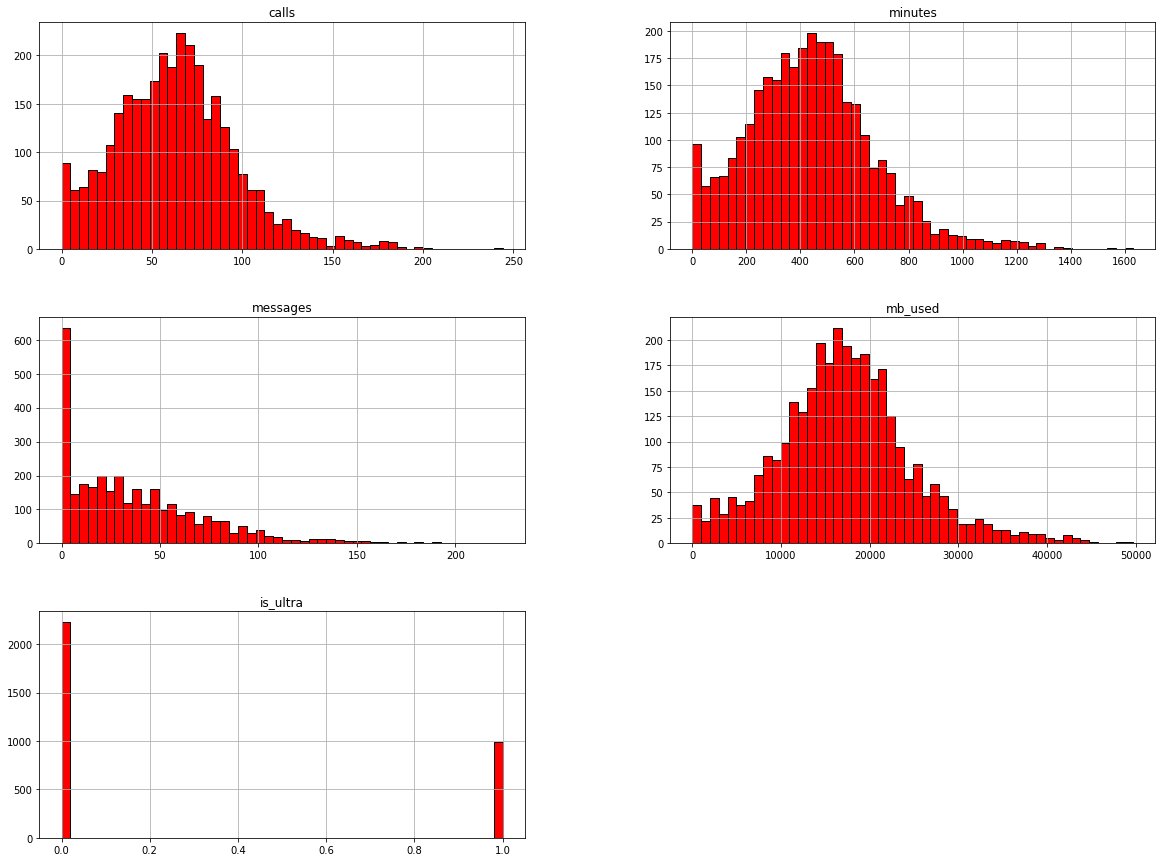

In [4]:
df.hist(bins=50, figsize=(20,15), color='r', edgecolor='black')
plt.show()

Абонентов тарифа "Смарт" почти в два раза больше, чем абонентов тарифа "Ультра". Распределения времени и количества звонков, а также использованного интернет-трафика носят характер, близкий к нормальному. При этом во времени и количестве звонков есть довольно большое количество выбросов, так как многие абоненты вообще не используют минуты. Распределение количества сообщений в месяц ближе к распределению Пуассона, однако здесь еще больше выбросов около нуля. Это может оказать негативное влияние на точность модели, поэтому при оценке точности можно попробовать обучать модели без данного признака.

Рассмотрим информацию в столбце с количеством сообщений подробнее. Определим долю абонентов каждого из тарифов, не использующих сообщения. Разные доли могут привести к снижению точности предсказания моделей.

In [5]:
print(f'Доля абонентов тарифа "Ультра", не использующих сообщения: {len(df.query("messages == 0 and is_ultra == 1")) / len(df[df["is_ultra"] == 1]): .1%}')
print(f'Доля абонентов тарифа "Смарт", не использующих сообщения: {len(df.query("messages == 0 and is_ultra == 0")) / len(df[df["is_ultra"] == 0]): .1%}')


Доля абонентов тарифа "Ультра", не использующих сообщения:  19.3%
Доля абонентов тарифа "Смарт", не использующих сообщения:  13.8%


### Вывод

После открытия файла и ознакомления с данными заменили тип данных на целочисленный в столбцах с информацией о количестве звонков и потраченных сообщениях. При выделении обучении моделей нужно уделить особое внимание столбцам с количеством звонков и с количеством сообщений. Количество звонков имеет распределение, похожее на количество минут разговора, но в этот столбец могут входить и звонки, оставшиеся без ответа, которые вряд ли влияют на выбор абонентом тарифа. Распределение количества сообщений имеет много выбросов около нуля. Это свидетельствует о том, что большое количество пользователей- 14% абонентов тарифа "Смарт" и 19% тарифа"Ультра"- вообще не отправляют сообщений, поэтому учет данного признака может привести к снижению точности моделей. Далее создадим четыре различных набора данных: один- со всеми признаками датасета, остальные три- исключая количество звонков, количество сообщений и исключая оба этих признака. Каждую модель протестируем на этих четырех наборах и выберем ту, которая покажет наилучший результат.

## Разбейте данные на выборки

Разобъем данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. В каждой выборке создадим переменные, содержащие признаки и целевой признак. Также создадим переменные для признаков и целевого признака для трех различных случаев: исключая количество звонков абонента, количество сообщений абонента и оба этих признака. Так мы получим возможность создать наиболее точную модель, если количество звонков абонента действительно дублирует столбец с минутами разговора, а количество сообщений не сильно влияет на выбор тарифа.

In [6]:
# создадим переменные для признаков и целевого признака в обучающей, валидационной и тестовой выборках
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)

# создадим переменные для признаков и целевого признака для трех случаев:

# исключая количество звонков
features_woc_train = features_train.drop(['calls'], axis=1)
features_woc_valid = features_valid.drop(['calls'], axis=1)
features_woc_test = features_test.drop(['calls'], axis=1)

# исключая количество сообщений
features_wom_train = features_train.drop(['messages'], axis=1)
features_wom_valid = features_valid.drop(['messages'], axis=1)
features_wom_test = features_test.drop(['messages'], axis=1)

# исключая оба этих признака
features_wob_train = features_train.drop(['calls', 'messages'], axis=1)
features_wob_valid = features_valid.drop(['calls', 'messages'], axis=1)
features_wob_test = features_test.drop(['calls', 'messages'], axis=1)
features_wo_both = df.drop(['calls', 'messages', 'is_ultra'], axis=1)

Рассмотрим результаты разбиения на выборки. Построим распределения количественных значений признаков в каждой выборке.


Text(0, 0.5, 'Доля абонентов')

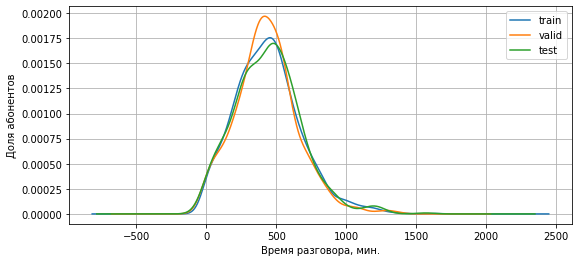

In [7]:
kwargs = {'kind':'kde', 'grid':True, 'figsize':(9,4), 'legend':'True'}
ax = features_train['minutes'].plot( **kwargs)
features_valid['minutes'].plot(**kwargs, ax=ax)
features_test['minutes'].plot(**kwargs, ax=ax)
ax.legend(['train', 'valid', 'test'])
plt.xlabel('Время разговора, мин.')
plt.ylabel('Доля абонентов')

Время разговора абонентов в месяц распределяется в обучающей, валидационной и тестовой выборках практически одинаково. Небольшое отклонение в максимуме есть только у валидационной выборки.

Text(0, 0.5, 'Доля абонентов')

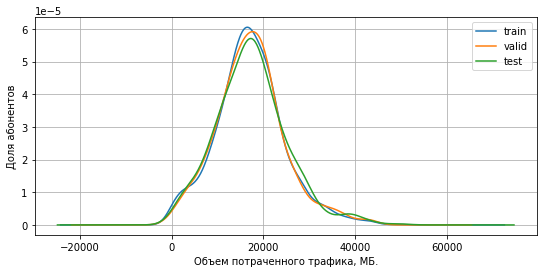

In [8]:
ax = features_train['mb_used'].plot( **kwargs)
features_valid['mb_used'].plot(**kwargs, ax=ax)
features_test['mb_used'].plot(**kwargs, ax=ax)
ax.legend(['train', 'valid', 'test'])
plt.xlabel('Объем потраченного трафика, МБ.')
plt.ylabel('Доля абонентов')

Распределение трафика по абонентам во всех трех выборках одинаковое.

Text(0, 0.5, 'Доля абонентов')

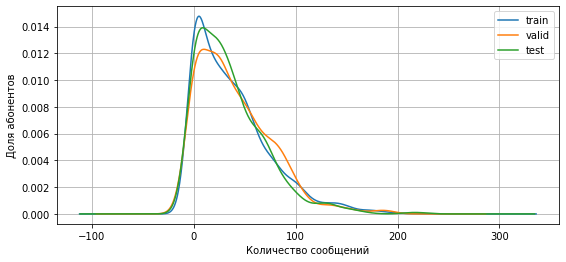

In [9]:
ax = features_train['messages'].plot( **kwargs)
features_valid['messages'].plot(**kwargs, ax=ax)
features_test['messages'].plot(**kwargs, ax=ax)
ax.legend(['train', 'valid', 'test'])
plt.xlabel('Количество сообщений')
plt.ylabel('Доля абонентов')

Распределение количества сообщений по абонентам в выборках имеет одинаковую форму, но разные значения. Скорее всего, это связано с большим количеством выбросов около нуля.

Text(0, 0.5, 'Доля абонентов')

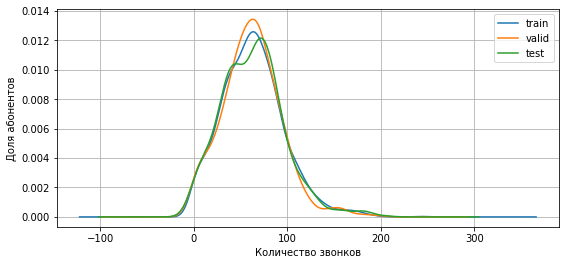

In [10]:
ax = features_train['calls'].plot( **kwargs)
features_valid['calls'].plot(**kwargs, ax=ax)
features_test['calls'].plot(**kwargs, ax=ax)
ax.legend(['train', 'valid', 'test'])
plt.xlabel('Количество звонков')
plt.ylabel('Доля абонентов')

Распределение количества звонков во всех трех выборках практически одинаковое.

### Вывод

При разбиении данных на обучающую, валидационную и тестовую выборки приняли соотношение 3:1:1. Распределения значений в итоговых выборках близки, что должно повлиять положительно на точность моделей. Добавили также обучающие, валидационные и тестовые выборки, исключая некоторые признаки: количество звонков, количество сообщений и оба этих признака вместе. Далее проверим, какой из наборов признаков дает наибольшую точность модели.

## Исследуйте модели

Для начала попробуем использовать модель логистической регрессии.

In [11]:
def log_reg_accuracy(features_train, features_valid, target_train, target_valid):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10000)
    model.fit(features_train, target_train)
    train_predictions = model.predict(features_train)
    valid_predictions = model.predict(features_valid)
    return (f'на обучающей выборке: {accuracy_score(target_train, train_predictions): .1%}, на валидационной выборке: {accuracy_score(target_valid, valid_predictions): .1%}')

print('Точность модели логистической регрессии со всеми признаками',
      log_reg_accuracy(features_train, features_valid, target_train, target_valid))

print('Без учета количества звонков',
      log_reg_accuracy(features_woc_train, features_woc_valid, target_train, target_valid))

print('Без учета количества сообщений',
      log_reg_accuracy(features_wom_train, features_wom_valid, target_train, target_valid))

print('Без учета количества звонков и сообщений',
      log_reg_accuracy(features_wob_train, features_wob_valid, target_train, target_valid))

Точность модели логистической регрессии со всеми признаками на обучающей выборке:  75.1%, на валидационной выборке:  72.6%
Без учета количества звонков на обучающей выборке:  75.1%, на валидационной выборке:  72.6%
Без учета количества сообщений на обучающей выборке:  69.5%, на валидационной выборке:  68.9%
Без учета количества звонков и сообщений на обучающей выборке:  69.5%, на валидационной выборке:  68.9%


При использовании модели логистической регрессии точность предсказания на всех признаках и без учета количества звонков имеет одинаковое значение. Точность модели без учета сообщений вопреки ожиданиям даже ниже, чем со всеми признаками. Точность модели без учета количества звонков и сообщений идентична точности модели без учеьа количества сообщений.

Далее проверим точность модели дерева решений.

In [12]:
def des_tree_accuracy(features_train, features_valid, target_train, target_valid):
    for depth in (1, len(features_train.columns)):
        best_result = 0
        model = DecisionTreeClassifier(max_depth = depth, random_state=12345)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_result = result
            best_model = model
            best_depth = depth
        train_predictions = best_model.predict(features_train)
        valid_predictions = best_model.predict(features_valid)
    return (f'на обучающей выборке: {accuracy_score(target_train, train_predictions): .1%}, на валидационной выборке: {accuracy_score(target_valid, valid_predictions): .1%}, глубина дерева: {best_depth}')

print('Точность модели дерева решений со всеми признаками',
      des_tree_accuracy(features_train, features_valid, target_train, target_valid))

print('Без учета количества звонков',
      des_tree_accuracy(features_woc_train, features_woc_valid, target_train, target_valid))

print('Без учета количества сообщений',
      des_tree_accuracy(features_wom_train, features_wom_valid, target_train, target_valid))

print('Без учета количества звонков и сообщений',
      des_tree_accuracy(features_wob_train, features_wob_valid, target_train, target_valid))

Точность модели дерева решений со всеми признаками на обучающей выборке:  82.1%, на валидационной выборке:  76.4%, глубина дерева: 4
Без учета количества звонков на обучающей выборке:  81.2%, на валидационной выборке:  76.5%, глубина дерева: 3
Без учета количества сообщений на обучающей выборке:  79.9%, на валидационной выборке:  76.2%, глубина дерева: 3
Без учета количества звонков и сообщений на обучающей выборке:  79.2%, на валидационной выборке:  75.7%, глубина дерева: 2


В случае использования модели дерева решений лучший результат также показывают наборы данных с включением всех признаков и с исключением количества звонков. Точность на валидационный выборке для них практически одинакова, однако во втором случае точность на обучающей выборке меньше на 1%. Так как разница между точностью на обучающей и валидационной выборках меньше во втором случае, примем ее как окончательную.

Далее протестируем модель случайного леса.

In [13]:
def rand_forest_accuracy(features_train, features_valid, target_train, target_valid):
    for est in (1, 5):
        for depth in (1, len(features_train.columns)):
            best_result = 0
            model = RandomForestClassifier(max_depth = depth, n_estimators = est, random_state=12345)
            model.fit(features_train, target_train)
            result = model.score(features_valid, target_valid)
            if result > best_result:
                best_model = model
                best_depth = depth
                best_est = est
    train_predictions = model.predict(features_train)
    valid_predictions = model.predict(features_valid)
    return (f'на обучающей выборке: {accuracy_score(target_train, train_predictions): .1%}, на валидационной выборке: {accuracy_score(target_valid, valid_predictions): .1%}, количество деревьев: {best_est}, глубина: {best_depth}')

print('Точность модели случайного леса со всеми признаками',
       rand_forest_accuracy(features_train, features_valid, target_train, target_valid))

print('Без учета количества звонков',
      rand_forest_accuracy(features_woc_train, features_woc_valid, target_train, target_valid))

print('Без учета количества сообщений',
      rand_forest_accuracy(features_wom_train, features_wom_valid, target_train, target_valid))

print('Без учета количества звонков и сообщений',
      rand_forest_accuracy(features_wob_train, features_wob_valid, target_train, target_valid))

Точность модели случайного леса со всеми признаками на обучающей выборке:  80.5%, на валидационной выборке:  76.7%, количество деревьев: 5, глубина: 4
Без учета количества звонков на обучающей выборке:  80.8%, на валидационной выборке:  77.0%, количество деревьев: 5, глубина: 3
Без учета количества сообщений на обучающей выборке:  80.1%, на валидационной выборке:  76.8%, количество деревьев: 5, глубина: 3
Без учета количества звонков и сообщений на обучающей выборке:  79.0%, на валидационной выборке:  76.0%, количество деревьев: 5, глубина: 2


При использовании модели случайного леса наибольшую точность на валидационной выборке показывает набор данных с исключением количества звонков пользователя - 77%. Стоит отметить, что и на остальных наборах данных модель показывает точность лишь немногим меньше.

### Вывод

При тестировании различных моделей на обучающей и валидационной выборках наихудший результат предсказания показала модель логистической регрессии. Лучшие результаты предсказания на валидационной выборке- у модели случайного леса - 77%. При использовании модели решающего дерева точность на обучающей выборке с различными наборами признаков составляет около 80%, а на валидиационной доходит до 76,5%. По условиям проекта минимальная точность модели составляет 75%. Так как модели дерева решений и случайного леса показывают примерно одинаковую точность на валидационных выборках, окончательный выбор модели сделаем после проверки их точности на тестовой выборке. Обучать обе модели будем на наборе данных без учета количества звонков абонента- в обоих случаях точность моделей, обученных на данном наборе данных, оказалась выше.

## Проверьте модель на тестовой выборке

In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3)
model.fit(features_woc_train, target_train)
predictions_test = model.predict(features_woc_test)
des_tree_accuracy = accuracy_score(target_test, predictions_test)
print(f'Точность модели решающего дерева с исключением количества звонков абонента и глубиной дерева равной 3 составляет {des_tree_accuracy: .2%}')

Точность модели решающего дерева с исключением количества звонков абонента и глубиной дерева равной 3 составляет  78.69%


In [15]:
model = RandomForestClassifier(n_estimators = 5, max_depth = 3, random_state=12345)
model.fit(features_woc_train, target_train)
predictions_test = model.predict(features_woc_test)
rand_forest_accuracy = accuracy_score(target_test, predictions_test)
print(f'Точность модели решающего дерева с исключением количества звонков абонента и глубиной дерева равной 3 составляет {rand_forest_accuracy: .2%}')

Точность модели решающего дерева с исключением количества звонков абонента и глубиной дерева равной 3 составляет  79.78%


### Вывод

На тестовой выборке точность обеих моделей также осталась достаточно высокой и даже превышает точность на валидационной выборке. При этом точность модели случайного леса немного выше точности модели решающего дерева, поэтому окончательно для прогнозирования подходящего тарифа для пользователей выберем модель случайного леса с количеством деревьев, равным 5, и глубиной дерева, равной 3.

## Проверьте модели на адекватность

Проверим модель на адекватность. Для этого создадим три набора данных для целевого признака- со случайным заполнением строк, с заполнением значением 0 и с заполнением значением 1. Для всех трех из них выведем на экран accuracy_score и сравним его с точностью выбранной модели- 79,8%.

In [16]:
check_columns = pd.DataFrame(np.random.randint(0, 2, size=(len(features_test), 1)), columns=['random'])
check_columns['only_false'] = 0
check_columns['only_true'] = 1
check_columns.head(10)
print(f'Точность со случайными значениями признака составляет {accuracy_score(target_test, check_columns["random"]): .1%}')
print(f'Точность с нулевыми значениями признака составляет {accuracy_score(target_test, check_columns["only_false"]): .1%}')
print(f'Точность со значениями признака, равными единице, составляет {accuracy_score(target_test, check_columns["only_true"]): .1%}')

Точность со случайными значениями признака составляет  49.0%
Точность с нулевыми значениями признака составляет  69.5%
Точность со значениями признака, равными единице, составляет  30.5%


### Вывод

Точность модели случайного леса на тестовой выборке составляет 79,8%. При заполнении признака случайными значениями точность предсказания колеблется около 50%. При заполнении нулевыми значениями и единицей точность предсказания составляет 69,5% и 30,5%, так как абонентов тарифа "Смарт" больше и, как следствие, значений целевого признака, равных нулю, также больше. В любом случае точность всех трех предсказаний значительно ниже точности выбранной модели, что подтверждает ее адекватность.

## Общий вывод

В ходе выполнения проекта были загружены и изучены данные об использовании абонентами тарифов "Ультра" и "Смарт". В исходном датасете дана информация о количестве звонков, длительности разговоров, количестве сообщений и количестве использованного трафика абонентами тарифов в месяц. 

Для обучения данные были разбиты на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Также были созданы различные выборки- с полным набором признаков, с исключением количества звонков, количества сообщений и с исключением обоих признаков. Для всех наборов данных были использованы модели логистической регрессии, дерева решений и случайного леса. Для последних двух моделей в цикле были рассмотрены различные гиперпараметры для получения наилучшей точности выбранной модели. Обе они показали хороший результат и были проверены на тестовой выборке. В результате была выбрана модель случайного леса с исключением количества звонков абонента глубиной дерева, равной 3, и количеством деревьев, равным 5.

На тестовой выборке окончательно выбранная модель показывает точность 79,8%.

Адекватность модели была проверена путем сравнения целевого признака тестовой выборки со случайными значениями, нулевыми значениями и значениями, равными единице. Во всех трех случаях точность предсказания получилась значительно ниже 79,8%, что говорит в пользу адекватности выбранной модели.

Пороговым значением выполнения проекта установлено 75%. Учитывая полученную точность выбранной модели на тестовой выборке в 79,8% можем сделать вывод, что проект выполнен в полном объеме.